# DATAIMPORT/ CLEANUP

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

import scipy.stats as stats



In [42]:
#orders_reeat_aot
suffix = "1_1_true"
existFilePath = os.path.join(r"D:\projects\private\Bachelorarbeit_Blazor_Wasm\BenchmarkResults", f"dfAll_{suffix}.csv")

if os.path.exists(existFilePath):
    dfAll = pd.read_csv(existFilePath)
else:
   
    path = r"C:\Users\cr\Downloads"
    dfAll = pd.DataFrame()

    for version in range(6):
        pattern = os.path.join(path, f"Version{version}_*{suffix}.txt")
        files = glob.glob(pattern)

        if files:
            for file in files:
                df = pd.read_csv(file, header=0, names=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])
                df["Version"] = f"Version{version}"
                df = df.loc[df.groupby(["ObjInstance", "MethodName"])["ElapsedMilliseconds"].idxmax()]
                dfAll = pd.concat([dfAll, df], ignore_index=True)

    dfAll.to_csv(existFilePath, index=False, encoding="utf-8")


In [43]:
dfAll = dfAll.dropna(subset=["ElapsedMilliseconds"])
dfAll = dfAll.drop_duplicates(subset=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])

dfAll["ElapsedMilliseconds"] = pd.to_numeric(dfAll["ElapsedMilliseconds"])
dfAll = dfAll[dfAll["ElapsedMilliseconds"] >= 0]

#Reihenfolge für Plots
custom_order = [
    "SetParam",
    "SetParam_OnInit",
    "GenerateOrders",
    "PopulateChartOrderState",
    "OnInit_OnParam",
    "OnParam_OnAfterRender",
    "VisualizeOrderStatusSuccess",
    "FINISH"
]

lifecycle = [
    "SetParam",
    "SetParam_OnInit",
    "OnInit_OnParam",
    "OnParam_OnAfterRender",
    "FINISH"
]


dfAll["MethodName"] = pd.Categorical(dfAll["MethodName"], categories=custom_order, ordered=True)
#Um das Gruppieren zum umgehen und bei Plots nach Version und Komponente zu unterscheiden
dfAll.loc[:, "VersionObjInstance"] = dfAll["Version"].astype(str) + " - " + dfAll["ObjInstance"].astype(str)

dfLifecycle = dfAll[dfAll["MethodName"].isin(lifecycle)]
dfLifecycle.loc[:, "VersionObjInstance"] = dfAll["Version"].astype(str) + " - " + dfAll["ObjInstance"].astype(str)





# CHECK SIGNIFICANCE

## PLOT

C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3883553201.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


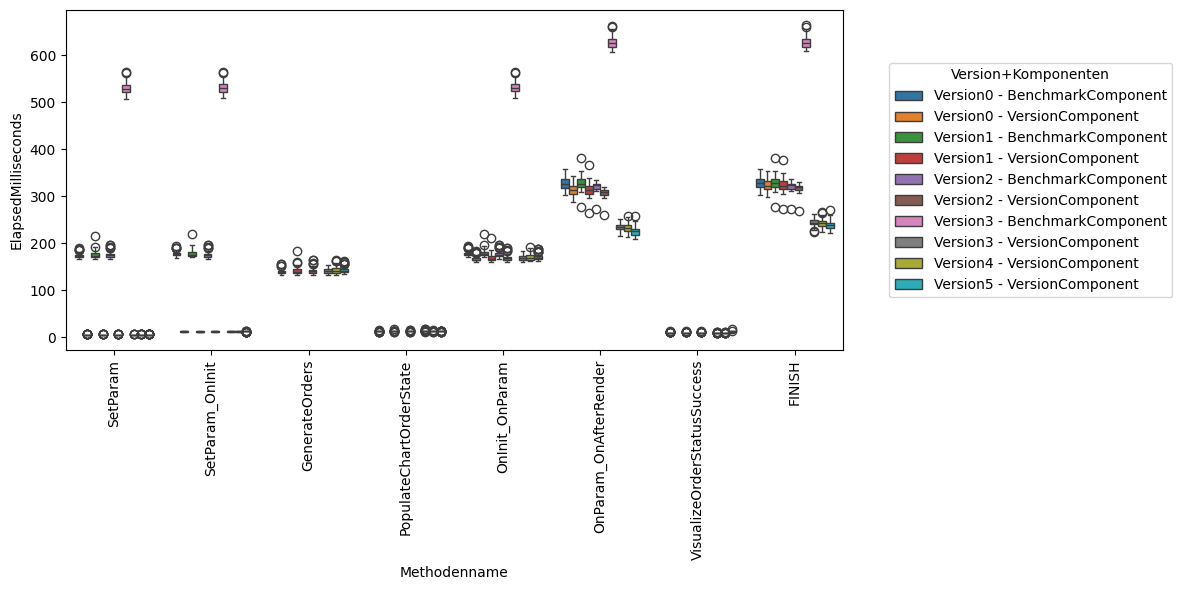

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Methodenname")
ax.set_ylabel("ElapsedMilliseconds")

plt.legend(title="Version+Komponenten", bbox_to_anchor=(1.05, 0.5), loc="center left")

plt.tight_layout()
plt.show()


C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3853449548.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3853449548.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3853449548.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


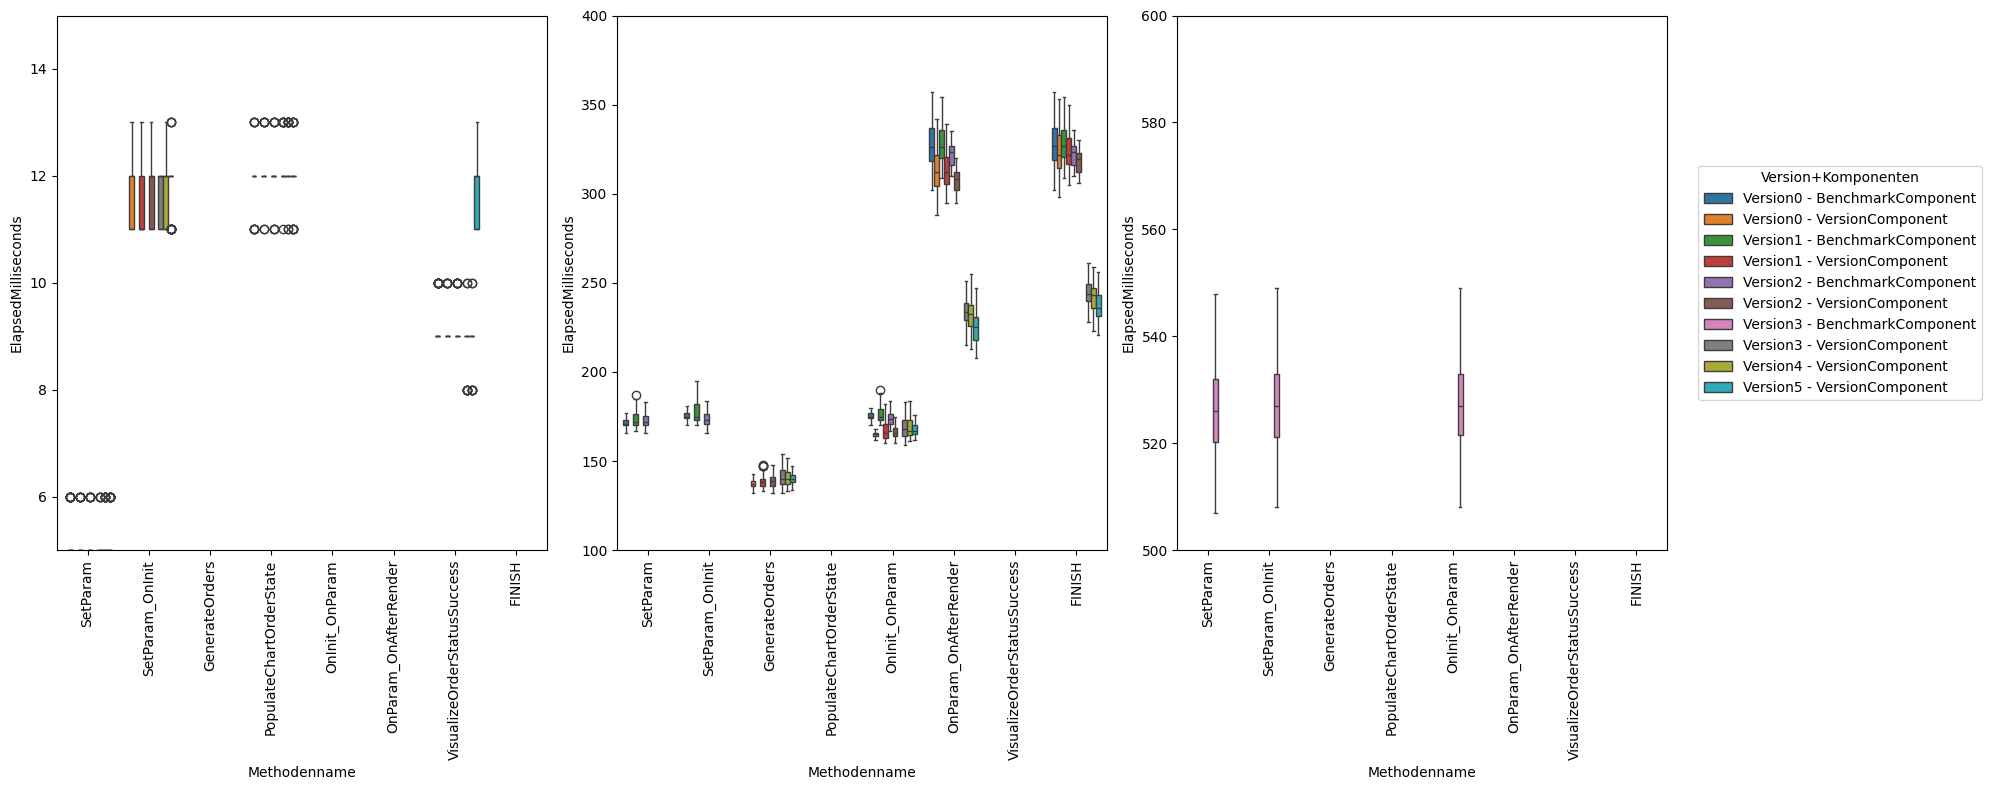

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax1, legend=False)
ax1.set_ylim(5, 15)

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax2 , legend=False)
ax2.set_ylim(100, 400)

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax3)
ax3.set_ylim(500, 600)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Methodenname")
    ax.set_ylabel("ElapsedMilliseconds")

plt.legend(title="Version+Komponenten", bbox_to_anchor=(1.05, 0.5), loc="center left")

plt.tight_layout()
plt.show()


In [65]:
#chatgpt
def remove_outliers_grouped(df, value_col, group_cols, threshold=1.5):
    def filter_group(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:
            IQR = 1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        return group[(group[value_col] > lower_bound) & (group[value_col] < upper_bound)]
    
    return df.groupby(group_cols, group_keys=False).apply(filter_group)

dfAll = remove_outliers_grouped(dfAll, "ElapsedMilliseconds", ["MethodName", "VersionObjInstance"])


C:\Users\cr\AppData\Local\Temp\ipykernel_21412\2881161756.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(filter_group)
C:\Users\cr\AppData\Local\Temp\ipykernel_21412\2881161756.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(filter_group)


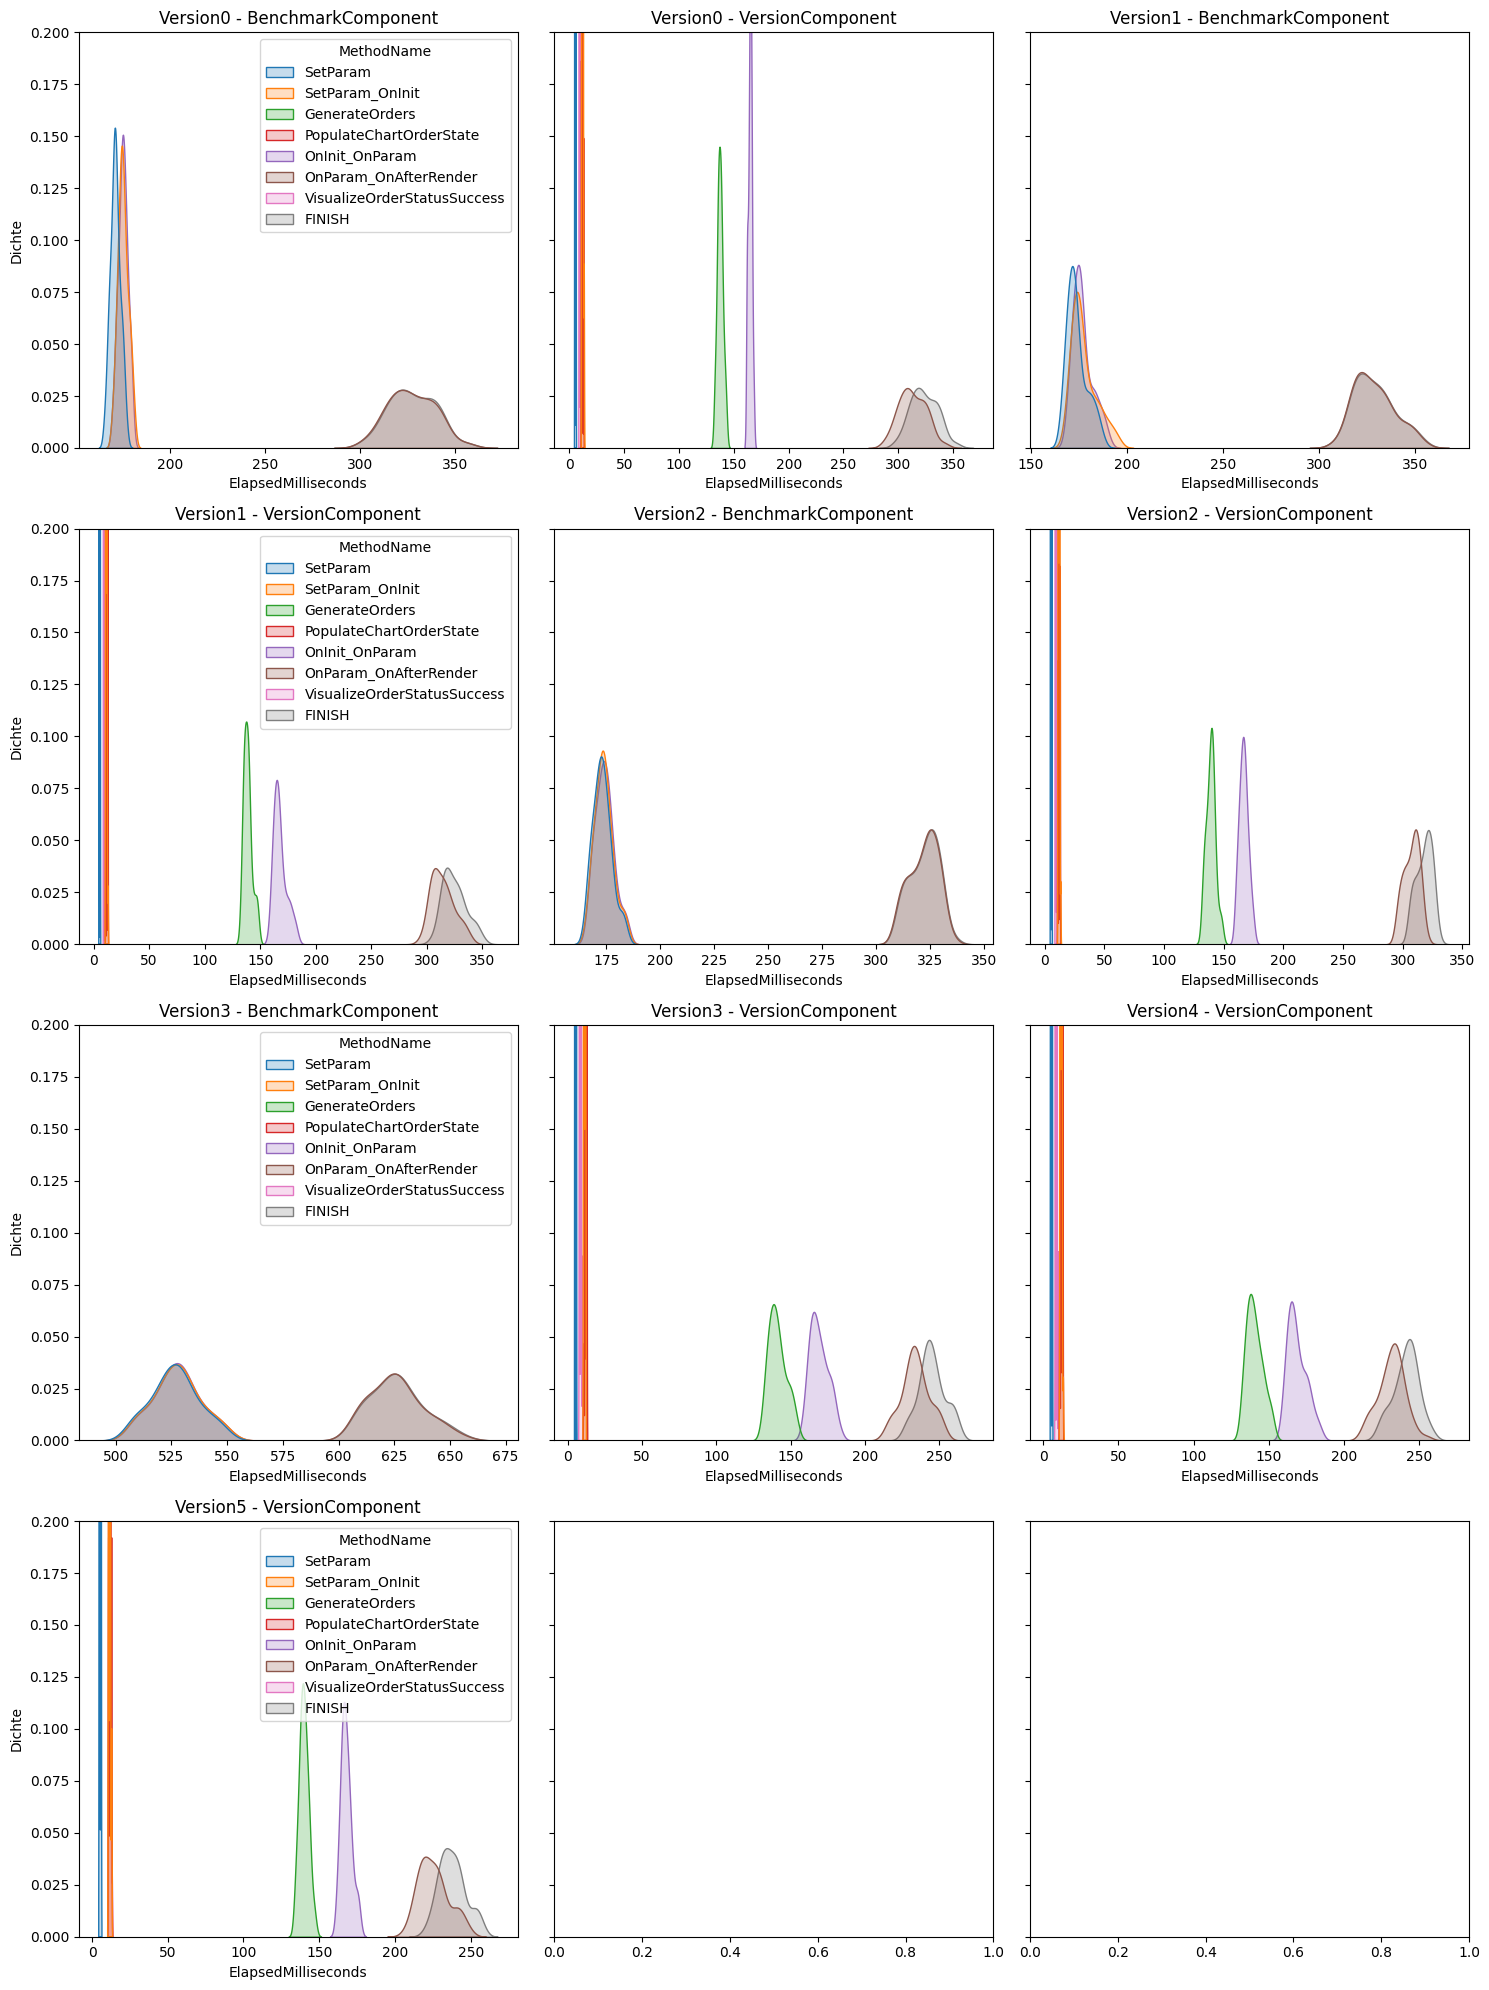

In [72]:
uniqueVersionObjInstances = dfAll["VersionObjInstance"].unique()

plots = len(uniqueVersionObjInstances)
cols = 3  
rows = (plots + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharey=True)
axes = axes.flatten()  

for i, VersionObjInstance in enumerate(uniqueVersionObjInstances):
    ax = axes[i]
    
    sns.kdeplot(data=dfAll[dfAll["VersionObjInstance"] == VersionObjInstance], 
                x="ElapsedMilliseconds", 
                hue="MethodName", 
                fill=True, 
                common_norm=False, 
                legend=True if i % 3 == 0 else False,
                ax=ax)
    ax.set_title(f"{VersionObjInstance}")
    ax.set_xlabel("ElapsedMilliseconds")
    ax.set_ylabel("Dichte")
    ax.set_ylim(0, 0.2)

plt.tight_layout()
plt.show()



## CALCULATION

In [68]:
uniqueVersionObjInstances = dfAll["VersionObjInstance"].unique()
uniqueMethods = dfAll["MethodName"].unique()

for version in uniqueVersionObjInstances:
    versionObjIni = dfAll[dfAll["VersionObjInstance"] == version]
    print(f"\n{version}")
    for method in uniqueMethods:
        #Fehler, weil kindkomponente nur lifecyclemethoden hat
        if (method not in lifecycle and (versionObjIni["ObjInstance"] == "BenchmarkComponent").any()):
            continue

        data = versionObjIni[versionObjIni["MethodName"] == method]["ElapsedMilliseconds"]
        if len(data) > 2:  
            modeResult = stats.mode(data).mode
            median = data.median()
            mean = data.mean()
            skew = stats.skew(data)
            
            # Unbiased Standardabweichung
            std = np.std(data, ddof=1) 
             # Variationskoeffizient
            vc = (std / mean) * 100 
             
            if vc > 5:
                print(f"Methode: {method}; Modus: {modeResult}; Median: {median}; Std: {vc:.2f}")
            
            if skew > 1:
                print(f"Methode: {method}; Rechtsschiefe: {skew:.2f};")
            if skew < -1:
                print(f"Methode: {method}; Linksschiefe: {skew:.2f};")
        else:
            print(f"Methode: {method}; Zu wenige Datenpunkte für Berechnungen.")
    



Version0 - BenchmarkComponent

Version0 - VersionComponent
Methode: SetParam; Modus: 5; Median: 5.0; Std: 7.11
Methode: SetParam; Rechtsschiefe: 1.88;
Methode: SetParam_OnInit; Modus: 11; Median: 12.0; Std: 5.22
Methode: VisualizeOrderStatusSuccess; Rechtsschiefe: 1.67;

Version1 - BenchmarkComponent
Methode: SetParam_OnInit; Rechtsschiefe: 1.06;

Version1 - VersionComponent
Methode: SetParam; Modus: 5; Median: 5.0; Std: 6.28
Methode: SetParam; Rechtsschiefe: 2.42;
Methode: VisualizeOrderStatusSuccess; Rechtsschiefe: 2.64;

Version2 - BenchmarkComponent

Version2 - VersionComponent
Methode: SetParam; Modus: 5; Median: 5.0; Std: 6.56
Methode: SetParam; Rechtsschiefe: 2.24;
Methode: VisualizeOrderStatusSuccess; Rechtsschiefe: 1.95;

Version3 - BenchmarkComponent

Version3 - VersionComponent
Methode: SetParam; Modus: 5; Median: 5.0; Std: 5.39
Methode: SetParam; Rechtsschiefe: 3.10;
Methode: PopulateChartOrderState; Rechtsschiefe: 1.08;

Version4 - VersionComponent
Methode: SetParam; Modu

In [69]:
def printStats(stats):
    print(f"{method}")
    print(stats,"\n") 


for VersionObjInstance in uniqueVersionObjInstances:

    versionA = dfAll.loc[dfAll["VersionObjInstance"] == VersionObjInstance]
    versionANum = versionA["Version"].str[-1].astype(int).iloc[0]
    versionB = dfAll.loc[
    (dfAll["Version"] == f"Version{versionANum + 1}") & 
    (dfAll["ObjInstance"] == versionA["ObjInstance"].iloc[0])
    ]
    if versionB.empty:
        continue
    print(f"\n{versionB["VersionObjInstance"].iloc[0]} zu {versionA["Version"].iloc[0]}")

    for method in uniqueMethods:
        if (method not in lifecycle and (versionA["ObjInstance"] == "BenchmarkComponent").any() or
            method not in lifecycle and (versionB["ObjInstance"] == "BenchmarkComponent").any()):
            continue
        
        statsTxt = ""
        versionAval = versionA[versionA["MethodName"] == method]["ElapsedMilliseconds"]
        versionBval = versionB[versionB["MethodName"] == method]["ElapsedMilliseconds"]
        
        if len(versionAval) < 2 or len(versionBval) < 2:
            print(f"Zu wenig Daten für {method}.")
            continue

        tStat, pVal = stats.ttest_ind(versionAval, versionBval, equal_var=False)
        uStatmann, pValmann = stats.mannwhitneyu(versionAval, versionBval)
        
        if pVal > 0.05:
            statsTxt += f"  welchs-statistik = {tStat}, p-Wert = {pVal}\n"
        
        if pValmann > 0.05:
            statsTxt += f"  Mann-U-statistik = {uStatmann}, p-Wert = {pValmann}"
        
        if statsTxt:
            printStats(statsTxt)




Version1 - BenchmarkComponent zu Version0
SetParam_OnInit
  Mann-U-statistik = 1531.0, p-Wert = 0.3281311409549761 

OnInit_OnParam
  Mann-U-statistik = 1415.0, p-Wert = 0.37151113002140357 

OnParam_OnAfterRender
  welchs-statistik = -0.7396287774136686, p-Wert = 0.4608905351411833
  Mann-U-statistik = 1925.0, p-Wert = 0.5092902123169023 

FINISH
  welchs-statistik = -0.6897034290898029, p-Wert = 0.4916399012380276
  Mann-U-statistik = 1951.5, p-Wert = 0.5930106862585778 


Version1 - VersionComponent zu Version0
SetParam
  welchs-statistik = 0.7052419463300772, p-Wert = 0.4819312272678382
  Mann-U-statistik = 2225.5, p-Wert = 0.48618237173215073 

SetParam_OnInit
  welchs-statistik = 1.2969180748874696, p-Wert = 0.19697475033450057
  Mann-U-statistik = 2357.0, p-Wert = 0.24459003717976446 

GenerateOrders
  Mann-U-statistik = 1202.0, p-Wert = 0.12002183173755995 

PopulateChartOrderState
  welchs-statistik = -1.0448000719078812, p-Wert = 0.29817036542290193
  Mann-U-statistik = 1849

# DATA EXPLORATION

C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3404266072.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfTilt = dfAll.pivot_table(
C:\Users\cr\AppData\Local\Temp\ipykernel_21412\3404266072.py:1: FutureWarning: The provided callable <function median at 0x0000024AC1354900> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  dfTilt = dfAll.pivot_table(


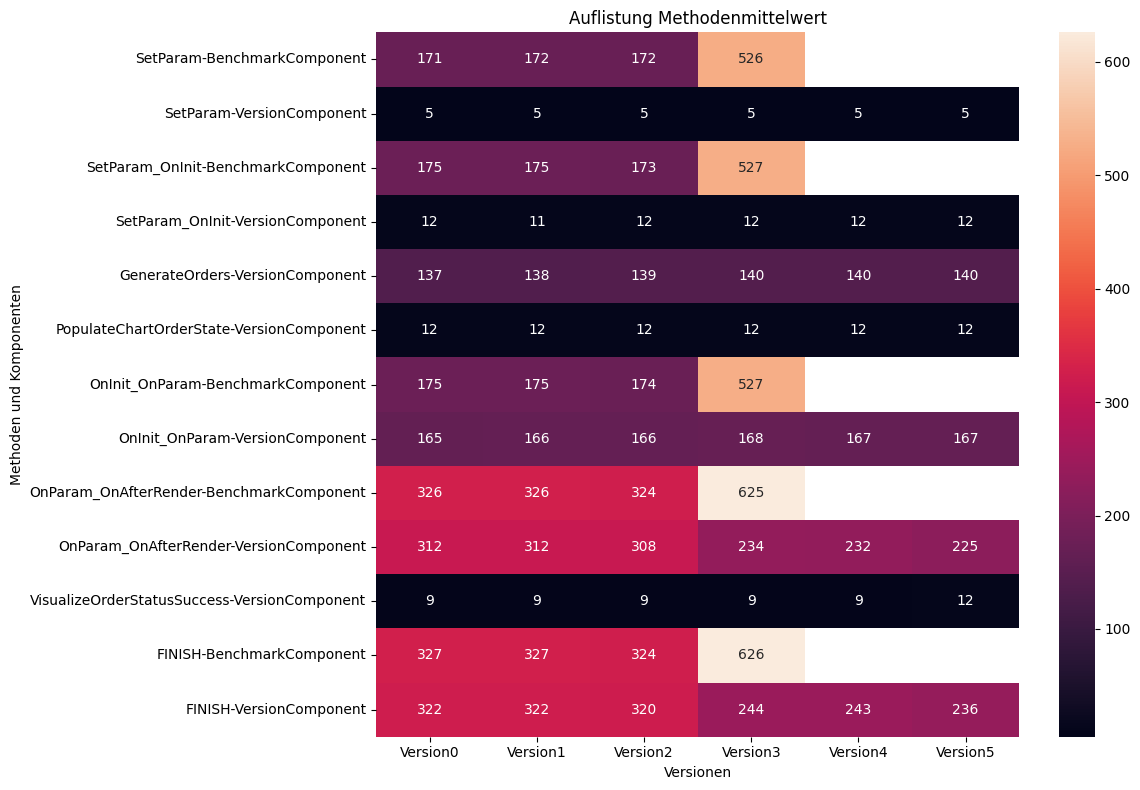

In [70]:
dfTilt = dfAll.pivot_table(
    values="ElapsedMilliseconds",
    index=["MethodName", "ObjInstance"],
    columns="Version",
    aggfunc=np.median
).sort_index(level=0)

plt.figure(figsize=(12, 8))
sns.heatmap(dfTilt, annot=True, fmt=".0f")

plt.title("Auflistung Methodenmittelwert")
plt.xlabel("Versionen")
plt.ylabel("Methoden und Komponenten")

plt.tight_layout()
plt.show()


In [71]:
fin = dfTilt.loc["FINISH"]
fin["%"] = ((fin["Version0"] - fin["Version5"]) / fin["Version0"]) * 100
print(fin[["Version0", "Version5", "%"]])

Version             Version0  Version5          %
ObjInstance                                      
BenchmarkComponent     327.0       NaN        NaN
VersionComponent       322.0     236.0  26.708075
